# KNN Classisfication - Heart Disease

## Introduction
___

**Heart diseases**, which are often caused by the narrowing of blood vessels, are the most common cause of death globally (CDC 2022). Recognizing the primary risk factors for heart disease is crucial for reducing mortality risks due to a heart disease. A research conducted by Hajar in 2017 highlights several key risk factors, including hypertension (high blood pressure), hypercholesterolemia (high cholesterol levels), and lack of physical activity. Therefore, this analysis aims to explore this question: **Can we predict a heart disease diagnosis based on age, serum cholesterol, resting blood pressure, maximum heart rate, and exercised-induced ST Depression, using KNN Classification?**

The *Heart Disease* dataset (1988) cotains patients' personal and health information such as age and cholesterol, incuding the metioned predictors in the above question. The dataset incudes the patients' heart disease diagnoses, which is categorical as 0 (indicating absence of heart disease) and 1 (indicating presence of heart disease). Here, the diagnosis for heart disease indicates >50% narrowing in any major blood vessel. The data includes some information which we do not need such as sex and thal, and it is provided from four different location in four different files. So it must be tidied and combined before it is analyzed.

## Methods
____

### 1. Loading and Cleaning Data

Let's start by installing libraries. `tidyverse` has functions which will help us to load and clean up our data, while `tidymodels` contains the tools we need to build and test our KNN model. 

In [1]:
# Install these libraries before continuing
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

As we work with the data, we will show many dataframes. We should ensure that only a small number like 6 rows show every time, so that the dataframes are not too overwhelming to look at.

In [2]:
options(repr.matrix.max.rows = 6)

As mentioned, this data is actually the combination of four datasets from four locations: Cleveland (USA), Hungary, Switzerland, Long Beach (USA).

Each dataset has a separate `.csv` file. We need to load in all four of these files from the web using `read_csv()`. The `.csv` files do not include the names of the correct columns, so we must add the names in manually.

In [3]:
# Reading data from web (stored in github repo)
cleveland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.cleveland.csv"
hungarian_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.hungarian.csv"
switzerland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.switzerland.csv"
beach_url <-  "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.va.csv"

names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thanl", "num")

cleveland <- read_csv(cleveland_url, col_names = names)
hungarian <- read_csv(hungarian_url, col_names = names)
switzerland <- read_csv(switzerland_url, col_names = names)
beach <- read_csv(beach_url, col_names = names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thanl
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thanl
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thanl
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to r

Let's take a look at one of the dataframes.

In [4]:
hungarian

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,?,?,1
58,0,2,180,393,0,0,110,1,1,2,?,7,1
65,1,4,130,275,0,1,115,1,1,2,?,?,1


The data includes information of patients, such as `age` (age in years). We will discuss each the meaning of each column as necessary. The `num` column, which will soon be described in more detail, and is what we want to predict.

This data is actually already 'tidy', which is to say:

- Each row is an observation of a single patient's information
- Each column is a single variable, which is some type of medical information
- Each cell is a single measurement.

We must combine the data into a single dataframe. Using `bind_rows` will keep the column names the same and join the dataframes vertically. The issue is that each dataset has different types for each column. It is simplest to change all columns of the datasets to the same type, doubles, which we will do first.

In [5]:
# Changing all columns to doubles to be able to combine the 4 dataframes
cleveland <- mutate_all(cleveland, as.double)
hungarian <- mutate_all(hungarian, as.double)
switzerland <- mutate_all(switzerland, as.double)
beach <- mutate_all(beach, as.double)

# Bind rows
heart_data_combined <- bind_rows(cleveland, hungarian, switzerland, beach)
heart_data_combined

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = .Primitive("as.double")(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see 

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,NA,NA,6,2
58,1,4,NA,385,1,2,NA,NA,NA,NA,NA,NA,0
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


(The warnings produced by the code mean that `?` values for missing data have been replaced with NA values.)

We now have one dataframe with data from **920** patients (as can be seen from the size of the tibble).

Let's take closer look at the `num` column, which as mentioned, is what we want to predict.

In [6]:
num_summary <- heart_data_combined |>
    group_by(num) |>
    summarize(count = n())

Table 1: `num` summary before processing

In [7]:
num_summary

num,count
<dbl>,<int>
0,411
1,265
2,109
3,107
4,28


So, `num` includes values from **0** to **4**. From the database description, 0 indicates the absence of heart disease, whereas values 1-4 suggest the presence of heart disease in increasing severity.

Our goal is only to classify the absence or presence of heart disease, and we do not need to introduce further complexity. Also, Hungarian data does not use the 1-4 scale and only uses the absence (0) and presence (1) classification.

So, we will simplify this by making all values from 1-4 into 1. In summary, `num` will be as follows:

- **`num = 0`** indicates the **absence** of patient disease (<50% narrowing of blood vessel diameter)
- **`num = 1`** indicates the **presence** of patient disease (>50% narrowing of blood vessel diameter)

We also need to change `num` from a double to a factor. This reflects the fact that it is categorical, and must be done before training the model.

In [8]:
heart_adjusted <- heart_data_combined |>
    mutate(num = ifelse(num %in% 1:4, 1, num)) |> # Change num values 1-4 to one
    mutate(num = as_factor(num)) # Convert to factor

heart_adjusted

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,NA,NA,6,1
58,1,4,NA,385,1,2,NA,NA,NA,NA,NA,NA,0
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


Look at the potential predictors that we have available (all columns except `num`). We have both continous predictors like `age`, and categorical predictors like `cp`, which is the type of chest pain. To be used properly as predictors, categorical variables require preprocessing, which is outside of the scope of this report.

Also, are going to remove observations with NAs from the data. Reducing the number of possible predictors before splitting the data into trainnig and testing can reduce the amount of lost information. For example, `thanl` might have lots of NAs, but if know we do not use `thanl`, then we don't need to remove all of those observations.

So, let's select only our possible continuous predictors, and then filter out all of our NA values.
We will be left with the following potential predictors:

- **`age`**: patient age (years)
- **`chol`**: serum cholesterol (mg/dl)
- **`trestbps`**: resting blood pressure (mmHg)
- **`thalach`**: maximum heart rate achieved during exercise (bps)
- **`oldpeak`**: ST depressing induced relative to exercise (this is a ratio)

*(**Note**: We are not yet choosing these as our final predictors).

There is also an incorrect value where `chol` is 0 to remove.

In [9]:
clean_heart <- heart_adjusted |>
    select(age, chol, trestbps, thalach, oldpeak, num) |>
    filter(!is.na(age), !is.na(chol), !is.na(trestbps), !is.na(thalach), !is.na(oldpeak), !is.na(num)) |> # Remove NAs
    filter(chol != 0)

clean_heart

age,chol,trestbps,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,233,145,150,2.3,0
67,286,160,108,1.5,1
67,229,120,129,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
54,333,127,154,0,1
55,223,122,100,0,1
62,254,120,93,0,1


Now, the number of patients we have information for has reduced from 920 to 672, which is still a workable amount of data.

Now we will split our data into:

- **training data**, which will be used to train our KNN model.
- **testing data** which will be used to test the accuracy of our KNN model.

We will split the data into 75% training and 25% testing. The splitting of data is a random process to ensure that data is chosen in an unbiased way. Setting the seed allows this random process to be reproduced.

In [10]:
# Split data into training (75%) and testing (25%) data
set.seed(1234)                    

heart_split <- initial_split(clean_heart, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

arrange(heart_train, age)
arrange(heart_test, age)

age,chol,trestbps,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,132,130,185,0,0
29,204,130,202,0,0
29,243,120,160,0,0
⋮,⋮,⋮,⋮,⋮,⋮
76,197,140,116,1.1,0
77,304,125,162,0.0,1
77,171,124,110,2.0,1


age,chol,trestbps,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
30,237,170,170,0,0
31,219,100,150,0,0
32,225,110,184,0,0
⋮,⋮,⋮,⋮,⋮,⋮
68,193,144,141,3.4,1
69,216,122,84,0.0,1
70,192,170,129,3.0,1


### 2. Preliminary Analysis

#### 2a. Data summaries

Now we have our clean data that we will use in our analysis, let's explore the training data a bit more.

In [11]:
heart_predictors <- heart_train |>
    select(age, chol, trestbps, thalach, oldpeak)
        
heart_means <- heart_predictors |>
    map_df(mean)

heart_max <- heart_predictors |>
    map_df(max)

heart_min <- heart_predictors |>
    map_df(min)

summaries <- bind_rows(heart_means, heart_max, heart_min)

summary_table <- tibble(summary = c("mean", "max", "min")) |>
    bind_cols(summaries)

Table 2: Data Summary

In [12]:
summary_table

summary,age,chol,trestbps,thalach,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean,52.82107,248.1113,132.9304,140.5964,0.9151093
max,77.00000,603.0000,200.0000,202.0000,6.2000000
min,28.00000,85.0000,92.0000,69.0000,0.0000000


These values tell us about how we will be able to use our model. For example, `age` only ranges between 28 and 77. If we used this as our predictor, the model may not be as accurate for people younger or older than this range. 

Also, let's look at the distribution of our predicted variable, `num`.

In [13]:
heart_obs <- heart_train |>
    group_by(num) |>
    summarize(count = n())

Table 3: `num` observations

In [14]:
heart_obs

num,count
<fct>,<int>
0,265
1,238


This tells us the number of 0 and 1 diagnoses present in the dataset are relatively even. This is good, because models perform optimally when the number of classes are balanced. If there were significantly more values where `num` was 0 than 1, the model would be biased towards predicting that `num` is 0.

#### 2b. Graphs (and Selecting Predictors)

We will generate two side-by-side **histograms** for each predictor, separated by `num`. This is a way of further understanding how our possible predictors are distributed.

It is also a rudimentary but useful way of determining whether a predictor might be relevant. We will also will supplement the analysis with scientific information about the relevance of each predictor.

In [71]:
# Plots visualizing distribution of each variable, separated by diagnosis of heart disease
options(repr.plot.width = 8) # Alter to fit screen

# Renaming num for plots only to make the legend clearer
heart_train_renamed_num <- heart_train |>
                            mutate(diagnosis = case_when(
                                num == 0 ~ "No Heart Disease(<50% diameter narrowing)",
                                num == 1 ~ "Heart Disease (>50% diameter narrowing)"
                            ))

y_lab = "Number of People"
leg_lab = "Heart Disease Diagonis"
text_size = 15

plot_age <- ggplot(heart_train_renamed_num, aes(x = age)) +
    geom_histogram(aes(fill = diagnosis), binwidth = 5) +
    labs(x = "Age (Years)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Figure 1: Distribution of Age") +
    theme(text = element_text(size = text_size))

plot_chol <- ggplot(heart_train_renamed_num, aes(x = chol)) +
    geom_histogram(aes(fill = diagnosis), binwidth = 30) +
    labs(x = "Serum Cholesterol (mg/dl)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Figure 2: Distribution of Serum Cholesterol") +
    theme(text = element_text(size = text_size))

plot_trestbps <- ggplot(heart_train_renamed_num, aes(x = trestbps)) +
    geom_histogram(aes(fill = diagnosis), binwidth = 10) +
    labs(x = "Resting Blood Pressure (mmHg)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Figure 3: Distribution of Resting Blood Pressure") +
    theme(text = element_text(size = text_size))

plot_thalach <- ggplot(heart_train_renamed_num, aes(x = thalach)) +
    geom_histogram(aes(fill = diagnosis), binwidth = 10) +
    labs(x = "Maximum Heart Rate (bpm)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Figure 4: Distribution of Maximum Heart Rate") +
    theme(text = element_text(size = text_size))

plot_oldpeak <- ggplot(heart_train_renamed_num, aes(x = oldpeak)) +
    geom_histogram(aes(fill = diagnosis), binwidth = 0.4) +
    labs(x = "ST Depression Induced by Exercise Relative to Rest (Ratio)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    theme(text = element_text(size = text_size)) +
    ggtitle("Figure 5: Distribution of ST Depression Induced by Exercise Relative to Rest") 

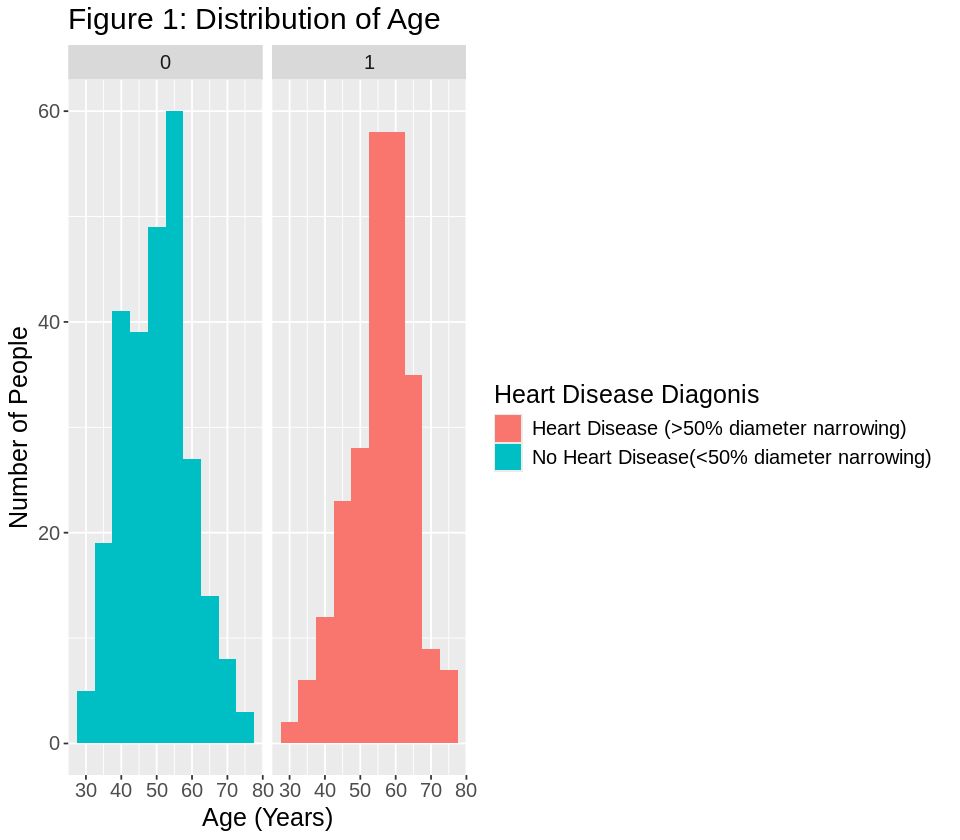

In [58]:
plot_age

- As age increases, the risk of cardiovascular diseases increases for both sexes (Jousilahti et. al 1999), as health generally declines with older age.
- We can see this represented in the training data. We see that the distribution for `num = 0` is slightly skewed towards the left, or toward a younger age, where `num = 1` is skewed somewhat further towards the right.
- In the model, this might mean a higher age will make the model more likely the presence of heart disease, or `num = 1`. So, age is likely a useful predictor.

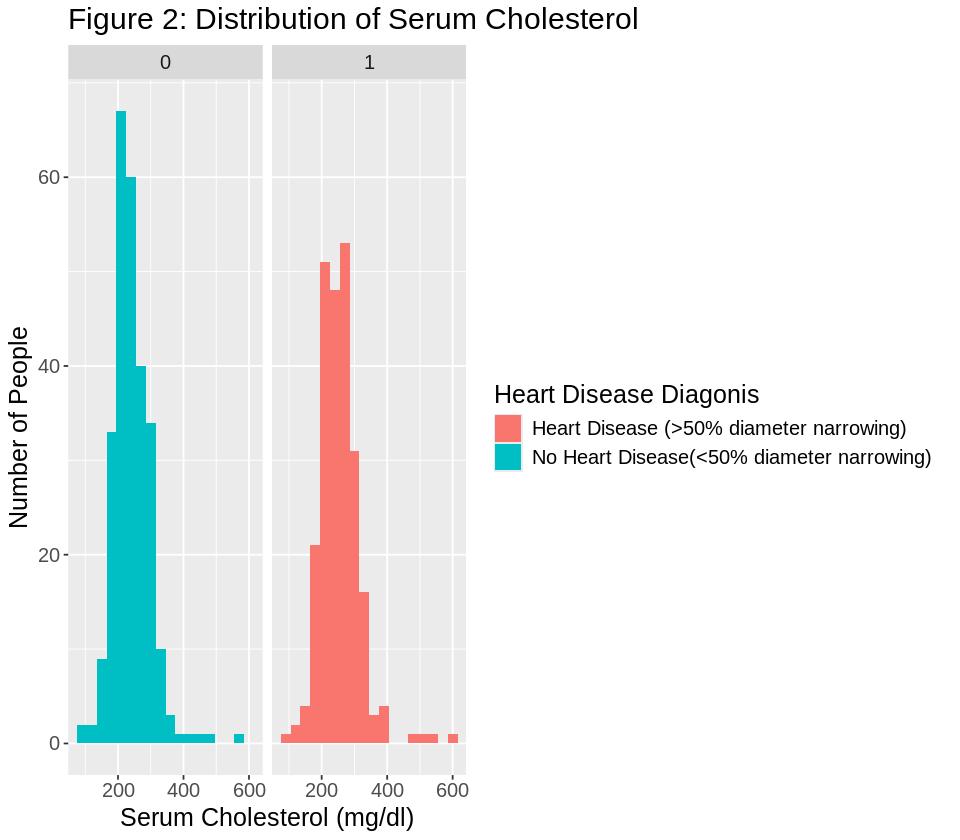

In [59]:
plot_chol

- High serum cholesterol is another well-known risk factor of heart disease (Hajar, 2017), as cholesterol directly affects cardiovascular health.
- We see that for those without heart disease (`num = 0`) it peaks at just under 200mg/dl. On the other hand, `num = 1` has a type of peak around 200-300. So, the trend of higher serum cholesterol being related with heart disease seems to be represented on the graph.

**Trestbps**

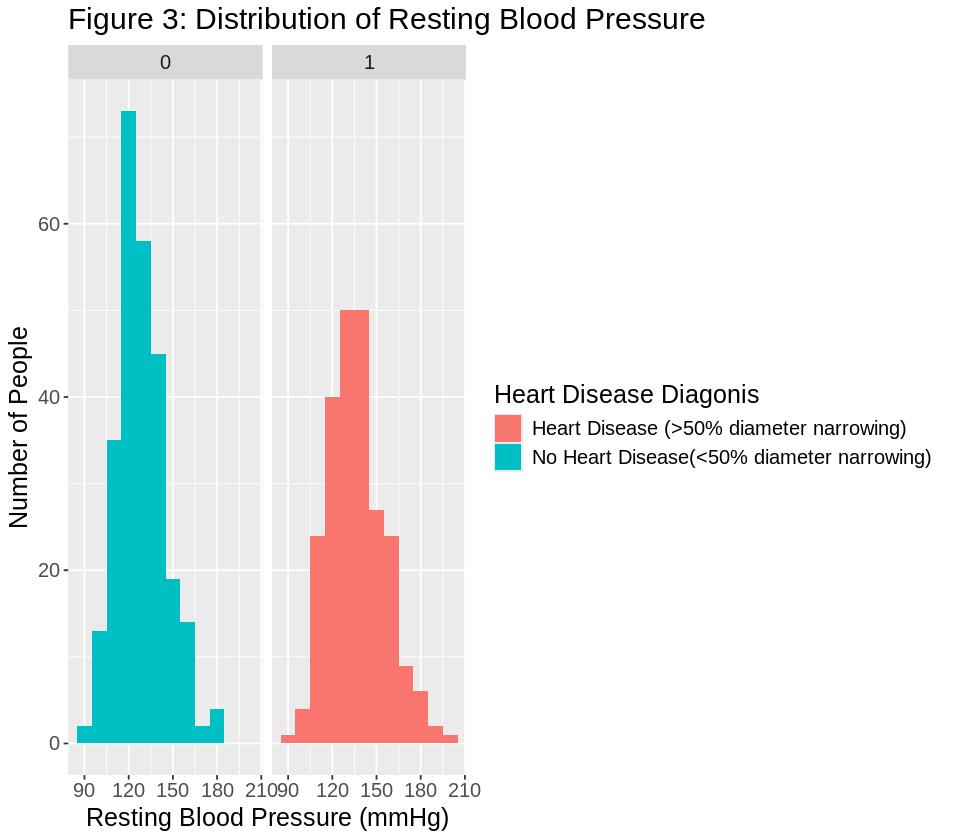

In [63]:
plot_trestbps

- High blood pressure also increases the risk of cardiovascular diseases (Hajar, 2017), and is related to changes in the health of blood vessels.
- It generally appears that when num=0, the distribution is skewed towards slightly lower values. The distribution of `trestbps` when `num = 1`, which has a comparatively more even distribution.

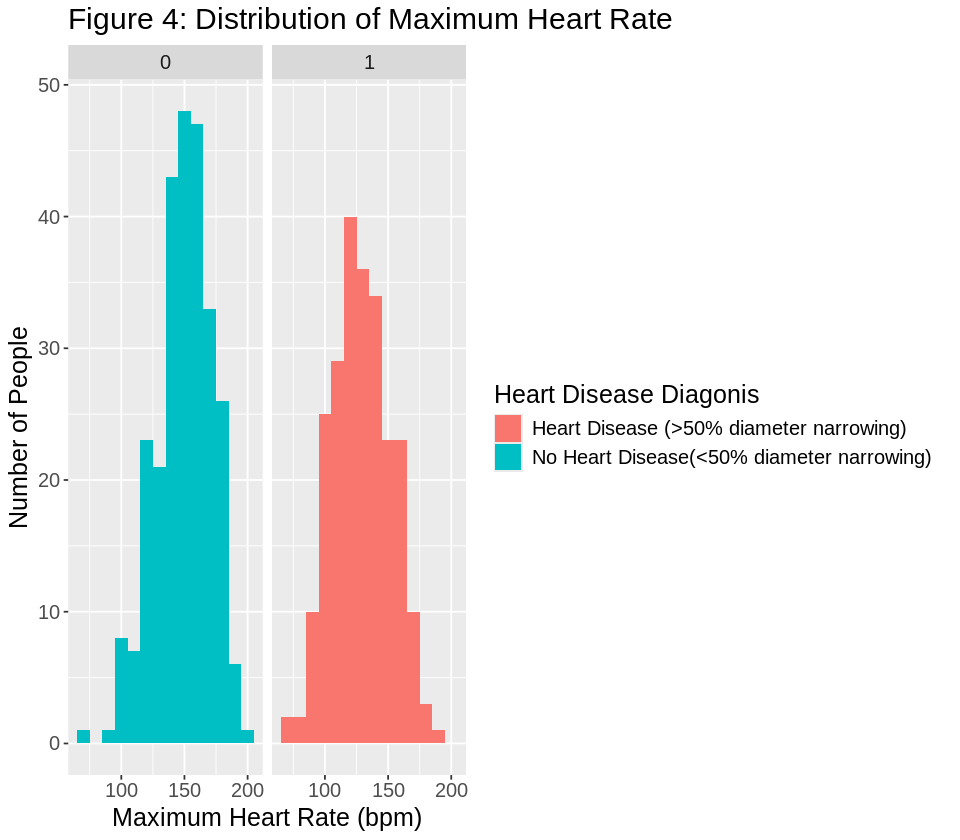

In [66]:
plot_thalach

- Maximal heart rate and the risk of cardiovascular disease are *inversely* correlated (Savonen et al., 2006), meaning that those with heart disease show a lower ability to raise heart rate during exercise.
- The distribution of `thalach` (maximal heart rate) may represent this. For those without heart disease (`num = 0`), the distribution has a rough peak aroun 150bpm. On the other hand, for those with heart disease, the data seems to be slightly centered around a value under 150bpm.
- But the difference between these two distributions is not as stark as the predictor candidates we have previously seen, so it is possible that this is not as strong a predictor.

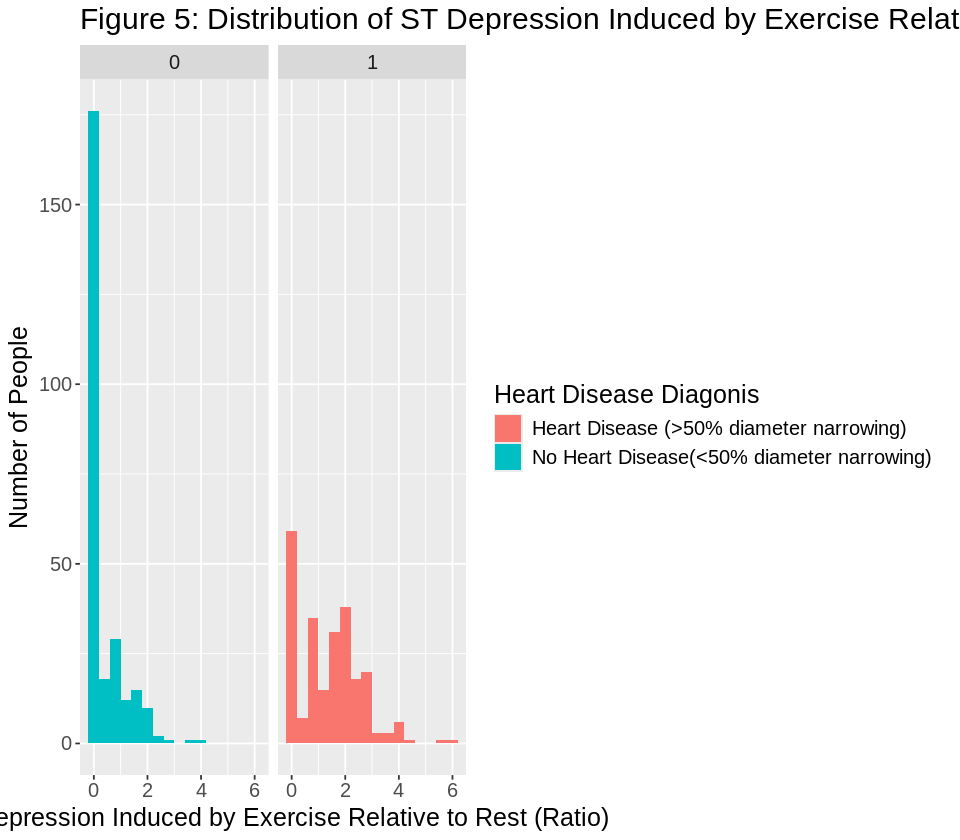

In [72]:
plot_oldpeak

- ST depression is a pattern that is sometimes observed on an ECG measurement. The frequency of ST depressions, both while the patient is exercising or resting, can be useful predictors of heart disease (Lanza et al., 2004).
- This measurement, `oldpeaks`, is the ratio of ST depression while exercising to ST depression while resting, so it incorporates both of these values.
- As seen on the graph above, when `num = 1` the oldpeaks values are overall much higher than when num=0. In fact, it appears that patients without heart disease (num=0) mostly have an oldpeaks value of 0, which indicates no ST depressions observed during exercise.
- So, generally speaking, this might indicate that our model will be more likely to predict patients with high oldpeaks values as having heart disease (num=1).

So, it looks like 5 of these predictors, including **`age`, `chol`, `trestbps`, `thalach`** and **`oldpeaks`** may be useful in our analysis.

### KNN Classification

For this model, we are using the k-nearest-neighbour classification with the predictors explored above.
- We first use the `tune()` and `vfold()` function to generate a tune the number of neighbours needed using a 5-fold cross validation
- Then we add the model to a workflow and collect the accuracy for each choice of the neighbour value k from 1 to 30

In [31]:
# Recipe (standardization)
set.seed(1234)

heart_recipe <- recipe(num ~ ., data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Define model specification - tune neighbors using 5-fold cross validation
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 5, strata = num)
vals <- tibble(neighbors = seq(from = 1, to = 30))

heart_accuracy <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(neighbors)

Now we use `ggplot()` and generate a line plot of accuracy vs. the number of neighbors used for k.

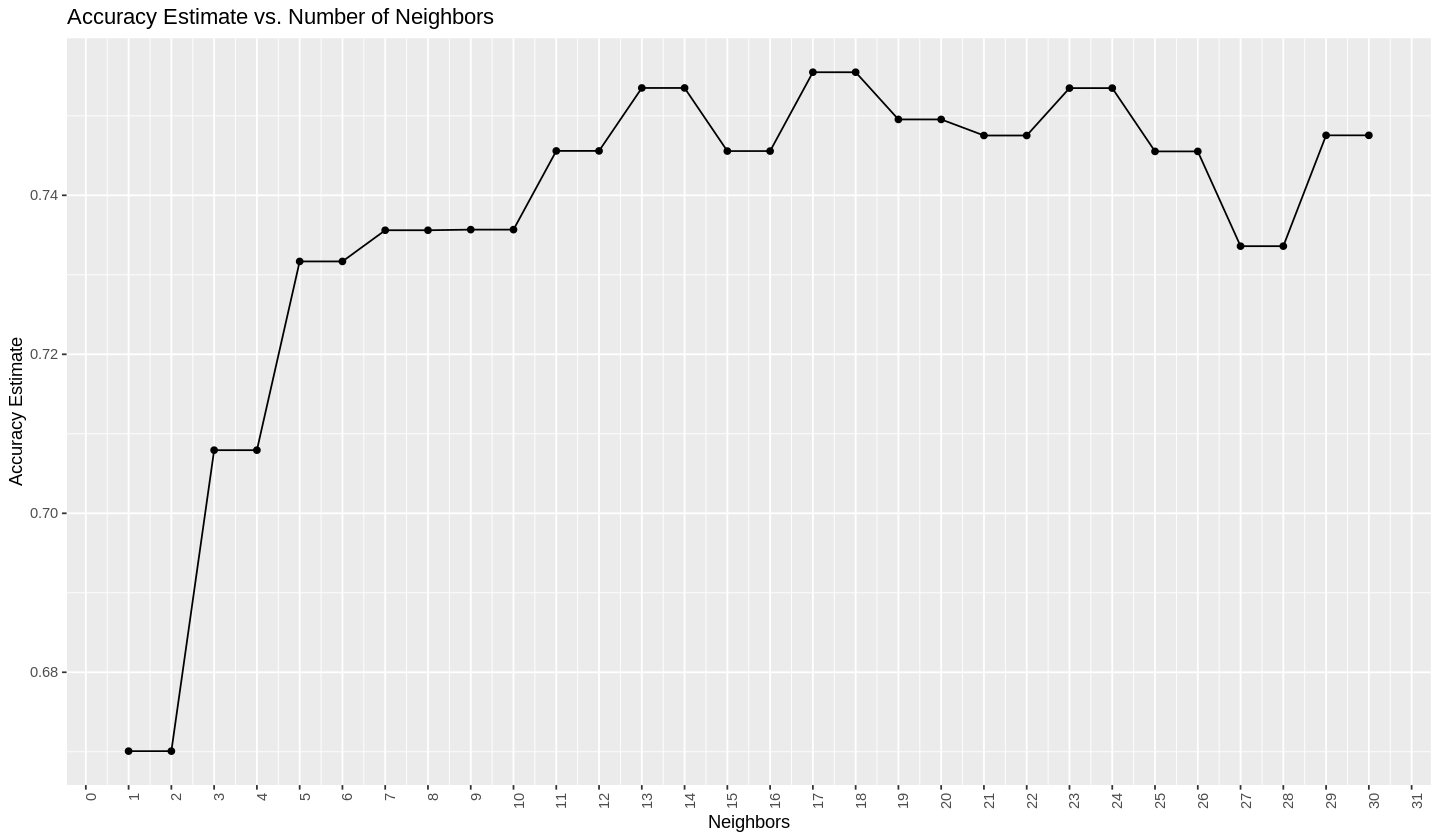

In [32]:
# Generate graph of accuracy
options(repr.plot.width = 12)
k_accuracies <- ggplot(heart_accuracy, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy Estimate vs. Number of Neighbors") +
       scale_x_continuous(breaks = seq(0, 100, by = 1)) +
       theme(axis.text.x = element_text(angle = 90, hjust = 1))

k_accuracies

- We can determine the best k by looking at the plot in conjunction with sorting out the highest accuracy using the `summarize()` function.
- We can see the number `k` of neighbours providing us with the highest accuracy is 17, which is a sensible value as it corresponds nicely to the accuracy stopping to increase afterwards through careful observation.
- Hereby we justify our choice of selecting `k = 17` for the rest of our model training.

In [33]:
# Determine best k

best_k <- heart_accuracy |>
    arrange(-mean) |>
    slice(1) |>
    select(neighbors) |>
    pull()

best_k

best_train_accuracy <- heart_accuracy |>
    summarize(accuracy = max(mean)) |>
    pull()

percent(best_train_accuracy)

[1] 17

[1] "76%"

We train our knn model accordingly with `k = 17` and fit it to our training data `heart_train`.

In [24]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_resample_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_train)

heart_resample_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2564612
Best kernel: rectangular
Best k: 17

Using the `bind_cols()` and `metrics()` function, the model provides us with a testing accuracy of `69%`, which is not the greatest but also not the worst as we will discuss this later.

In [25]:
# Prediction on the testing data
heart_test_predict = predict(heart_resample_fit, heart_test)|>
    bind_cols(heart_test)

# heart_train_resample_predict
heart_test_accuracy <- metrics(data = heart_test_predict, truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy")|>
    pull()

heart_test_accuracy

[1] 0.6923077

We now generate a *confusion matrix* as well as a *recall / precision* calculation for a better understanding of the *performance* of the model

In [45]:
# Confusion Matrix
confusion <- heart_test_predict |>
             conf_mat(truth = num, estimate = .pred_class)

recall = heart_test_predict |> 
        recall(truth = num, estimate = .pred_class, event_level = "second") |>
        select(.metric, .estimate)
precision = heart_test_predict |> 
        precision(truth = num, estimate = .pred_class, event_level = "second") |>
        select(.metric, .estimate)

confusion
recall
precision

          Truth
Prediction  0  1
         0 75 38
         1 14 42

.metric,.estimate
<chr>,<dbl>
recall,0.525


.metric,.estimate
<chr>,<dbl>
precision,0.75


## Citations
Hajar, R. (2017). Risk factors for coronary artery disease: Historical perspectives. Heart Views, 18(3), 109–109. https://doi.org/10.4103/heartviews.heartviews_106_17


Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. Heart Disease UCI Machine Learning Repository [Data set]. https://doi.org/10.24432/C52P4X

Heart Disease and Stroke. (2022 8 September). CDC. https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=The%20Nation's%20Risk%20Factors%20and,unhealthy%20diet%2C%20and%20physical%20inactivity.

Jousilahti, P., Vartiainen, E., Tuomilehto, J., Puska, P. Sex, Age, Cardiovascular Risk Factors, and Coronary Heart Disease. (1999). Circulation, 99, 1165-1172. https://doi.org/10.1161/01.CIR.99.9.1165

Lanza, G. A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G. A., Crea, F. (2004). Diagnostic and prognostic value of ST segment depression limited to the recovery phase of exercise stress test. *Heart, 90*(12), 1417-1421. https://doi.org/10.1136/hrt.2003.031260

Savonen, K., Lakka, T. A., Laukkanen, J. A., Halonen, P. M., Rauramaa, T. H., Salonen, J. T., Rauramaa, R. (2006). Heart rate response during exercise test and cardiovascular mortality in middle-aged men. *European Heart Journal, 27*(5), 582-588. https://doi.org/10.1093/eurheartj/ehi708

Citations and in-text citations excluded from word count